# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%run imports_notebook.py

In [3]:
sys.executable

'/work/08258/akumar01/maverick2/miniconda3/bin/python'

In [4]:
import torch
import clip
from PIL import Image

net_clip, preprocess = clip.load("ViT-B/32", device=device)


In [5]:
import lpips
net_lpips = lpips.LPIPS(net='alex').to(device)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [6]:
count_params(net_clip)/1e6, count_params(net_lpips)/1e6

(151.277313, 2.470848)

In [70]:
image = preprocess(Image.open("imgs/dog.png")).unsqueeze(0).to(device)
text = clip.tokenize(["a diagram", "a dog", "a cat"]).to(device)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    
    logits_per_image, logits_per_text = model(image, text)
    probs = logits_per_image.softmax(dim=-1).cpu().numpy()

print("Label probs:", probs)  # prints: [[0.9927937  0.00421068 0.00299572]]

/work/08258/akumar01/maverick2/miniconda3/lib/python3.9/site-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


NameError: name 'model' is not defined

In [9]:
import optimization

  0%|                                                                                                                                                                                                                | 0/2000 [00:00<?, ?it/s]

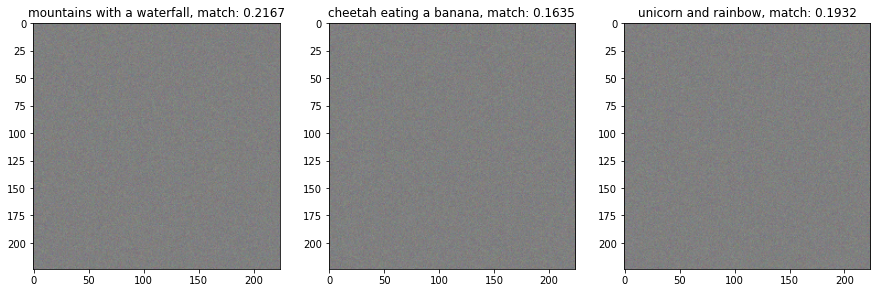

 10%|███████████████████▋                                                                                                                                                                                  | 199/2000 [00:11<01:40, 17.84it/s]

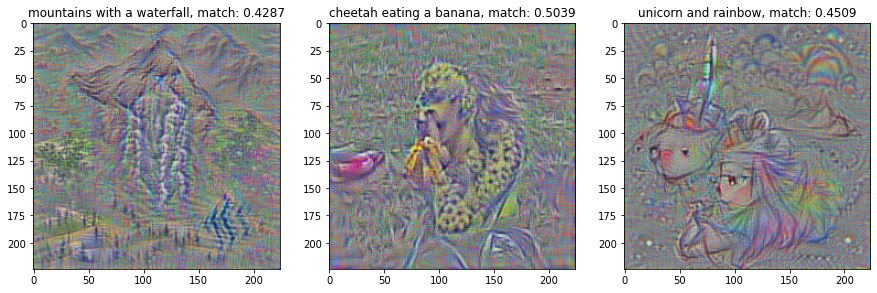

 20%|███████████████████████████████████████▌                                                                                                                                                              | 400/2000 [00:22<01:30, 17.77it/s]

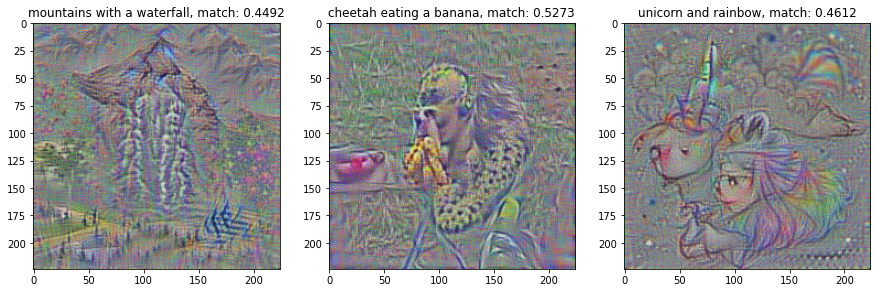

 24%|████████████████████████████████████████████████▏                                                                                                                                                     | 487/2000 [00:28<01:27, 17.33it/s]


RuntimeError: CUDA error: misaligned address
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [9]:
torch.manual_seed(1032)

texts = ["mountains with a waterfall", "cheetah eating a banana", "unicorn and rainbow"]

def callback(i_iteration, texts, imgs, imgs_augments, imgs_features, texts_features, dots, loss):
    if i_iteration%200==0:
        dots_img = dots.mean(dim=0).tolist()
        plt.figure(figsize=(5*len(imgs), 5))
        for i_img, img in enumerate(imgs):
            plt.subplot(1, len(imgs), i_img+1)
            plt.title(texts[i_img] + f', match: {dots_img[i_img]:.4f}')
            plt.imshow(to_np(img.permute(1, 2, 0)))
        plt.show()
        
    
    
optimization.optimize_imgs(model, texts, imgs='pixel', n_iterations=2000, lr=5e-2, device=device, callback=callback)

CPPN -> multiple latent noise Images -> augmented Images for each one-> 
- all agumented images are "trees"
- all latent noise images have different

In [16]:
#       n, 3, H, W (one image for each CPPN)
#    n, L, 3, H, W (multiple latent images for each CPPN)
# n, L, A, 3, H, W (multiple agumentations for multiple latent images for each CPPN)

In [18]:
img = torch.randn(1, 5, 3, 224, 224)
utils.single_batch_map(optimization.augment_img, img, instance_shape=(3, 224, 224), n_augments=2).shape
# optimization.augment_img(img, 2).shape

torch.Size([1, 5, 2, 3, 224, 224])

In [10]:
def pts(x, name=None): # print tensor stats
    if name is None:
        name = ''
    print(f'{name:>20}: ', end='')
        
    if isinstance(x, torch.Tensor):
        print(x.shape, x.dtype, x.device, x.requires_grad)
    else:
        print(x)
def calc_pairwise_lpips_dist(im0, im1):
    """
    im0 has shape A, 3, 224, 224
    im1 has shape B, 3, 224, 224
    returns a tensor of shape A, B corresponding to pairwise distances
    """
    return torch.stack([net_lpips(im0i, im1)[:, 0, 0, 0] for im0i in im0])

In [134]:
import random

          vclip_text: torch.Size([512]) torch.float16 cuda:0 False


  0%|          | 0/1000 [00:00<?, ?it/s]


loss.item()=-0.23291015625 loss_clip.item()=-0.23291015625 loss_lpips.item()=-0.05070606619119644
[[-0.9246624112129211, -0.4253440499305725], [-2.643845796585083, 0.14518386125564575], [-0.12086646258831024, -0.5797257423400879]]


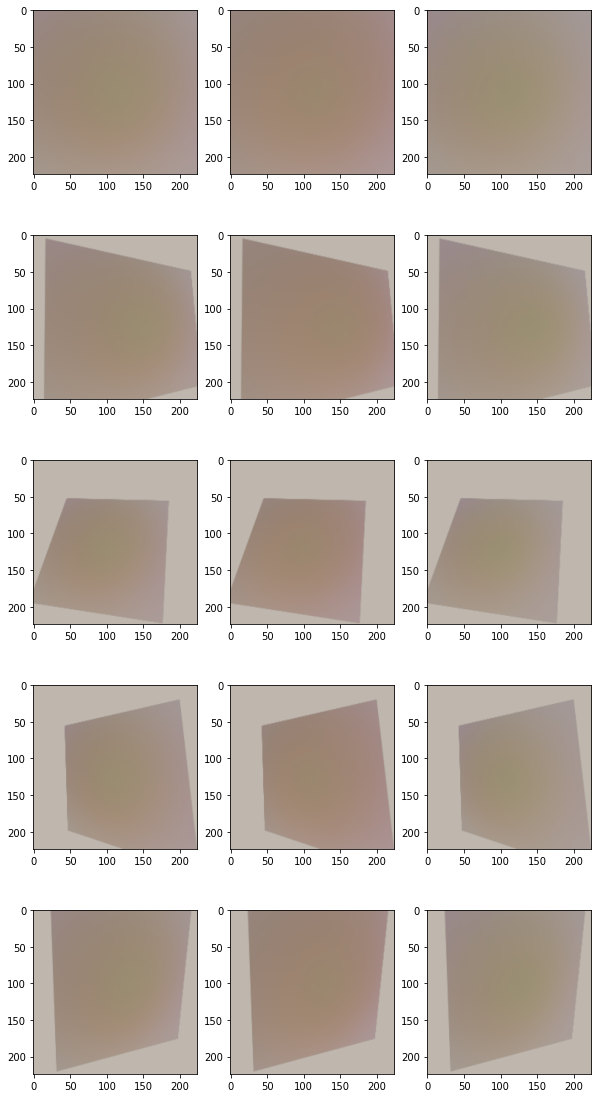


loss.item()=-0.291259765625 loss_clip.item()=-0.291259765625 loss_lpips.item()=-0.015540567226707935
[[-0.6832625269889832, -0.6901421546936035], [0.5402733087539673, 0.030182911083102226], [-0.24305282533168793, 0.0251508466899395]]


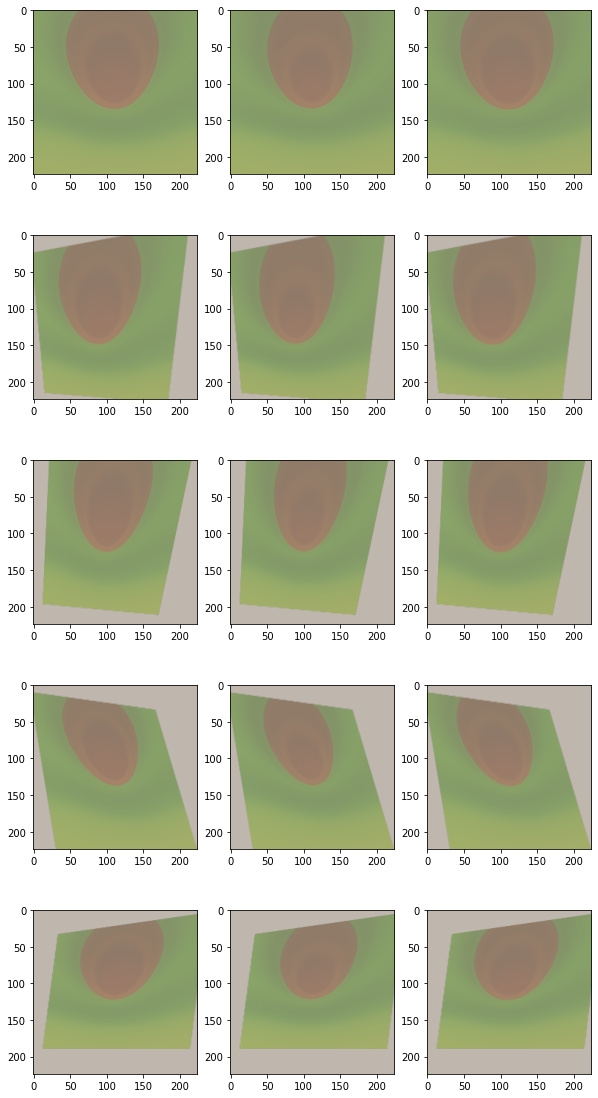

KeyboardInterrupt: 

In [137]:
seed=0;random.seed(seed);np.random.seed(seed); torch.manual_seed(seed)

text = clip.tokenize(["a tree"]).to(device)
with torch.no_grad():
    vclip_text = net_clip.encode_text(text)[0]
    
pts(vclip_text, 'vclip_text')

n_batches, n_latent, dim_latent = 1, 3, 2
n_aug = 5

cppn = ImageCPPN(n_batches=n_batches, dim_latent=dim_latent, normalization=None, activation=torch.tanh, residual=True).to(device)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-2)

pbar = tqdm(range(1000))
for idx_batch in pbar:
    latents = torch.randn(n_latent, dim_latent, device=device)
    imgs = torch.stack([cppn.generate_image(latent=latent) for latent in latents], dim=1)
    # pts(imgs, 'imgs')
    imgs_aug = utils.single_batch_map(optimization.augment_img, imgs, instance_shape=(3, 224, 224), n_augments=n_aug, keep_original=True)
    # pts(imgs_aug, 'imgs_aug')
    vclip_imgs = utils.single_batch_map(net_clip.encode_image, imgs_aug.cuda(), instance_shape=(3, 224, 224))
    # pts(vclip_imgs, 'vclip_imgs')
    # n, L, A, D (multiple agumentations for multiple latent images for each CPPN)
    d_lpips = calc_pairwise_lpips_dist(imgs[0], imgs[0])
    d_lpips.fill_diagonal_(0) # ignore pairwise same image to same image
    # pts(d_lpips, 'd_lpips')

    loss_clip = -torch.cosine_similarity(vclip_imgs, vclip_text, dim=-1).mean()
    loss_lpips = -d_lpips.mean()
    loss = loss_clip#+0.*loss_lpips
    # loss = loss_lpips

    opt.zero_grad()
    loss.backward()
    opt.step()

    pbar.set_postfix({'loss': loss.item(), 'loss_clip': loss_clip.item(), 'loss_lpips': loss_lpips.item()})
    
    if idx_batch%100==0:
        print()
        print(f'{loss.item()=} {loss_clip.item()=} {loss_lpips.item()=}')
        print(f'{latents.tolist()}')
        plt.figure(figsize=(10, 20))
        i = 0
        for imgrow in imgs_aug[0].permute(1, 0, 2, 3, 4):
            for img in imgrow:
                i+=1
                plt.subplot(n_aug, n_latent, i)
                imshow(img)
                # plt.xticks([]);plt.yticks([])
        plt.show()
    # break

# The above isn't reproducible. Why not? figure out why? I seed all RNGs

In [104]:
torch.cuda.memory_allocated()/1e9

1.063130624

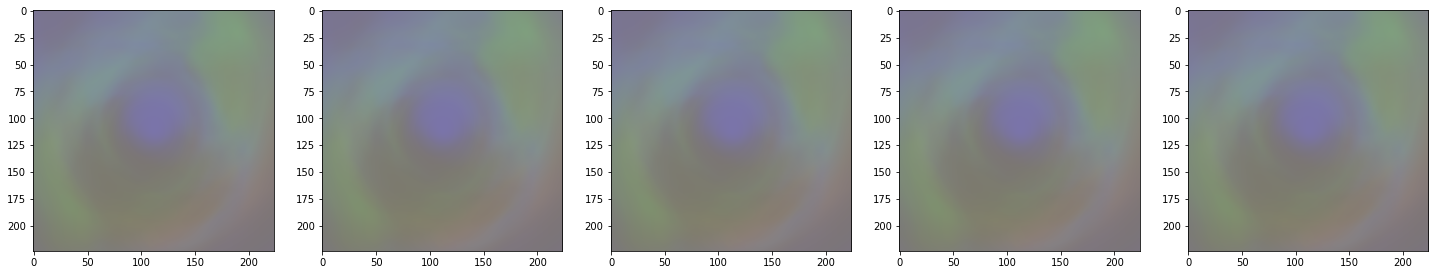

In [175]:
plt.figure(figsize=(len(imgs[0])*5, 5))
for i, img in enumerate(imgs[0]):
    plt.subplot(1, len(imgs[0]), i+1)
    imshow(img)
plt.show()

In [92]:
np.random.seed(0); torch.manual_seed(0)
x = torch.randn(4, 3, 224, 224)
y = torch.randn(4, 3, 224, 224)
print(net_lpips(x, y).reshape(4))
print(net_lpips(x, y).shape)
print()

for xi, yi in zip(x, y):
    print(net_lpips(xi, yi))
    

tensor([0.1923, 0.1715, 0.1891, 0.1897], grad_fn=<ReshapeAliasBackward0>)
torch.Size([4, 1, 1, 1])

tensor([[[[0.1923]]]], grad_fn=<AddBackward0>)
tensor([[[[0.1715]]]], grad_fn=<AddBackward0>)
tensor([[[[0.1891]]]], grad_fn=<AddBackward0>)
tensor([[[[0.1897]]]], grad_fn=<AddBackward0>)


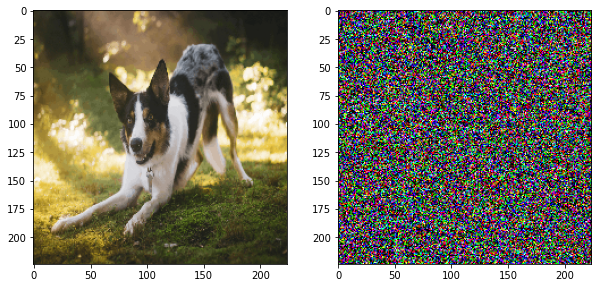

  0%|          | 0/1000 [00:00<?, ?it/s]

1.4871596097946167


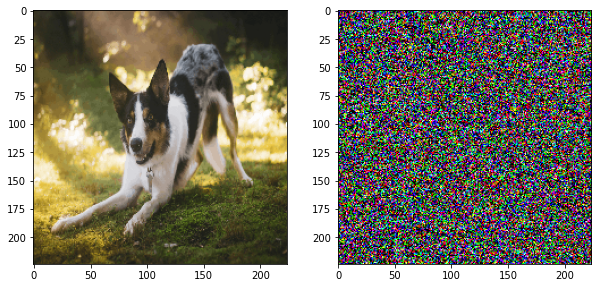

0.22199620306491852


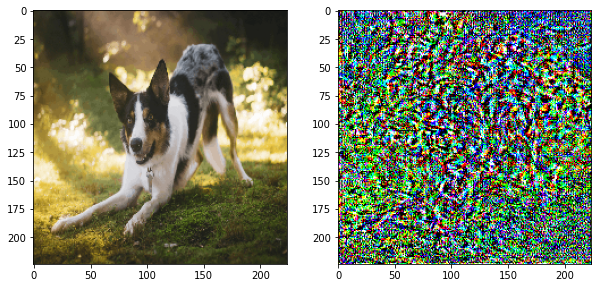

0.13233478367328644


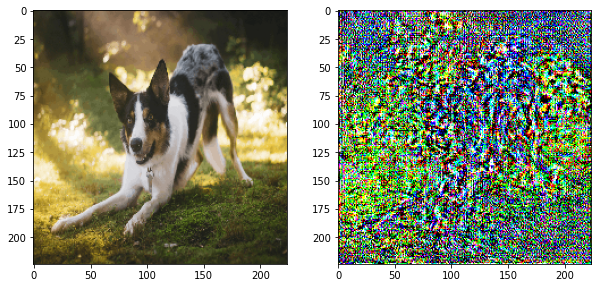

0.1001535952091217


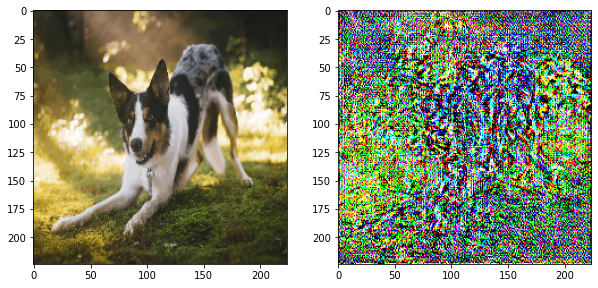

0.08336522430181503


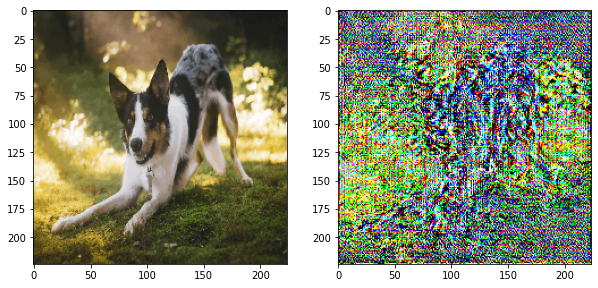

0.06897725909948349


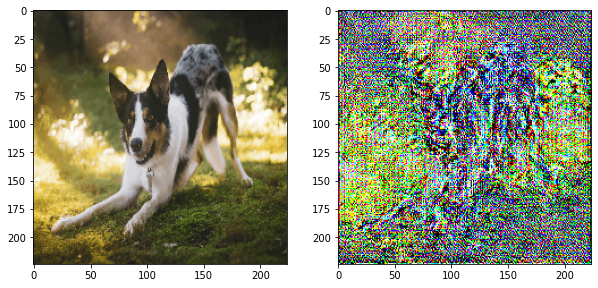

0.06002134084701538


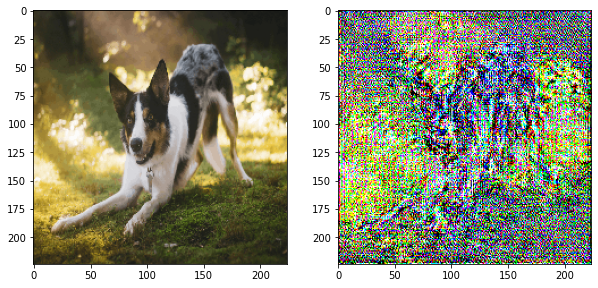

0.05216570943593979


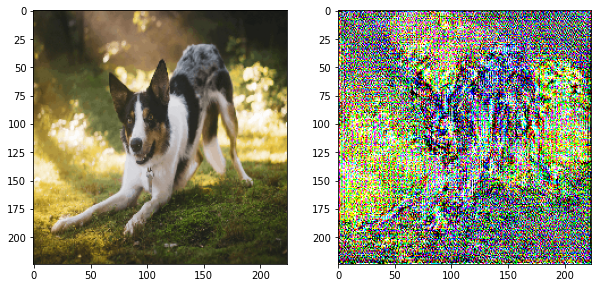

0.046503812074661255


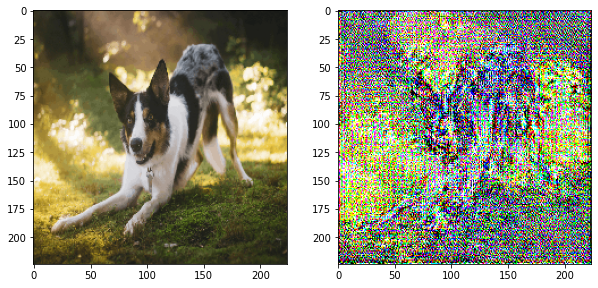

0.04371240362524986


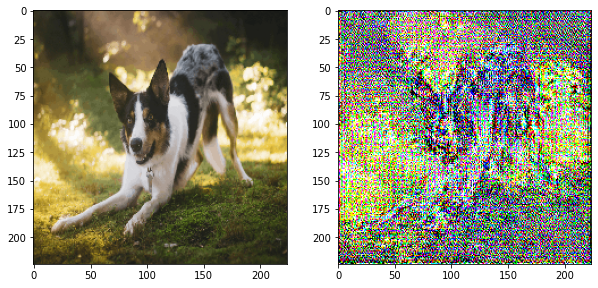

In [126]:
np.random.seed(0); torch.manual_seed(0)
a = plt.imread('imgs/dog.png')[:, :, :3]
a = torch.from_numpy(a).permute(2, 0, 1)
a = transforms.RandomResizedCrop(224, scale=(.9, .9))(a)
b = torch.randn(3, 224, 224)

plt.figure(figsize=(10, 5))
plt.subplot(121); imshow(a, mean=None, std=None)
plt.subplot(122); imshow(b, mean=None, std=None)
plt.show()

b.requires_grad_()

opt = torch.optim.Adam([b], lr=1e-1)


for i in tqdm(range(1000)):
    loss = net_lpips(a, b)
    opt.zero_grad()
    loss.backward()
    opt.step()
    
    if i%100==0:
        print(loss.item())
        plt.figure(figsize=(10, 5))
        plt.subplot(121); imshow(a, mean=None, std=None)
        plt.subplot(122); imshow(b, mean=None, std=None)
        plt.show()



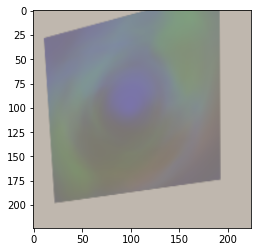

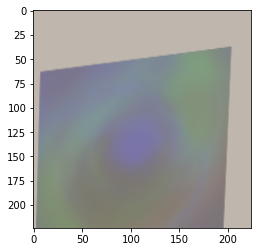

In [ ]:
imshow(imgs[0,1, 0])
plt.show()
imshow(imgs[0,1, 1])
plt.show()

In [ ]:
def generate_input(img_size=(224, 224), n_batches=1, features=['x', 'y', 'r'], device='cpu'):
    inputs = (img_size, n_batches, features, device)
    h, w = img_size
    y, x = torch.linspace(-1, 1, h, device=device), torch.linspace(-1, 1, w, device=device)
    y, x = torch.meshgrid(y, x, indexing='ij')
    r = (x.pow(2)+y.pow(2)).sqrt()
    theta = torch.atan2(x, y)
    absy, absx = y.abs(), x.abs()
    feature2data = {'y': y, 'x': x, 'r': r, 'theta': theta, 'absy': absy, 'absx': absx}
    x = torch.stack([feature2data[key] for key in features], dim=0)[None] # (1, n_features, h, w)
    # normalize
    x = (x-x.mean(dim=(-1, -2), keepdim=True))/x.std(dim=(-1, -2), keepdim=True)
    x = x.repeat(1, n_batches, 1, 1) # (1, n_batches*n_features, h, w)
    x = x.to(device)
    return x

In [44]:
def imshow(img, mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711]):
    """
    img.shape should be (3, h, w) on any device, torch tensor
    """
    img = img.detach().cpu()
    img = img.permute(1, 2, 0)
    if std is not None:
        img = img*torch.tensor(std)
    if mean is not None:
        img = img+torch.tensor(mean)
    img = img.clamp(0, 1).numpy()
    plt.imshow(img)
    
    

In [ ]:
from torchvision import transforms

augment_trans = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.5, p=1, fill=1),
    transforms.RandomResizedCrop(224, scale=(0.7,0.9)),
])

def augment_img(img, n_augments, augment='noise'):
    imgs = [img]
    
    if augment=='noise':
        for i in range(n_augments):
            imgs.append(img+1e-2*torch.randn_like(img))
    if augment=='crops':
        for i in range(n_augments):
            imgs.append(augment_trans(img))
    
    return torch.cat(imgs, dim=0)

def augment_img(img, n_augments, augment='crops', keep_original=False):
    imgs = []

    if keep_original:
        imgs.append(img)
    
    if augment=='noise':
        for _ in range(n_augments):
            imgs.append(img+1e-2*torch.randn_like(img))
    if augment=='crops':
        for _ in range(n_augments):
            imgs.append(augment_trans(img))
    
    return torch.stack(imgs, dim=0)

# Optimizing Pixels

In [ ]:

text = clip.tokenize(["mountains with a waterfall"]).to(device)
text_features = model.encode_text(text)
target = text_features[0].detach()

torch.manual_seed(5)

img = 1e-2*torch.randn(1, 3, 224, 224)
img = img.to(device)
# img = img.requires_grad_()
img.requires_grad = True

opt = torch.optim.Adam([img], lr=3e-2, weight_decay=1e-6)

for i in tqdm(range(10000)):
    img_augments = augment_img(img, 4, augment='crops')
    image_features = model.encode_image(img_augments)
    
    dots = torch.cosine_similarity(image_features, target)
    loss = -dots.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i%200==0:
        print(loss.item())
        imshow(img[0])
        plt.show()



# Optimizing CPPN to a CLIP Text

In [ ]:
from image_cppn import ImageCPPN

In [ ]:
print('starting')
text = clip.tokenize(["dog eating a banana"]).to(device)
text_features = model.encode_text(text)
target = text_features[0].detach()

torch.manual_seed(5)

cppn = ImageCPPN(n_hidden=20, n_layers=8, n_channels=3, activation=torch.relu, give_radius=True)
cppn = cppn.to(device)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-3)#, weight_decay=1e-6)

for i in tqdm(range(10000)):
    img = cppn.generate_image((224, 224))
    img = img*2-1.
    img_augments = augment_img(img, 4, augment='crops')
    image_features = model.encode_image(img_augments)
    
    dots = torch.cosine_similarity(image_features, target)
    loss = -dots.mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i%200==0:
        print(loss.item())
        imshow(img[0])
        plt.show()



# Optimizing CPPN to a target image

This doesn't work according to this example:
https://silky.github.io/cppn-playground/
But does according to 
https://cs.stanford.edu/people/karpathy/convnetjs/demo/image_regression.html


Basically just use relu activation and not tanh/sigmoid

In [20]:
imgs = ['imgs/dog.png', 'imgs/malik.jpg', 'imgs/waterfall.jpg']
imgs = torch.stack([preprocess(Image.open(i)) for i in imgs])


In [37]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7f20d6c38790>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [ ]:
imshow(target)

In [ ]:
torch.manual_seed(5)

cppn = BatchImageCPPN()
cppn = cppn.to(device)

opt = torch.optim.Adam(cppn.parameters(), lr=1e-3)#, weight_decay=1e-6)

for i in tqdm(range(100)):
    img = cppn.generate_image((224, 224))
    loss = (img-target.to(img)).pow(2).mean()
    
    opt.zero_grad()
    loss.backward()
    opt.step()

    if i%10==0:
        print("Loss: ", loss.item())
    #     imshow(img[0])
    #     plt.show()
